# Nearest Neighbors

Given a point cloud, or data set $X$, and a distance $d$, a common computation is to find the **nearest neighbors** of a target point $x$, meaning points $x_i \in X$ which are closest to $x$ as measured by the distance $d$.

Nearest neighbor queries typically come in two flavors:
1. Find the `k` nearest neighbors to a point `x` in a data set `X`
2. Find all points within distance `r` from a point `x` in a data set `X`

There is an easy solution to both these problems, which is to do a brute-force computation

## Brute Force Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.spatial
import scipy.spatial.distance as distance

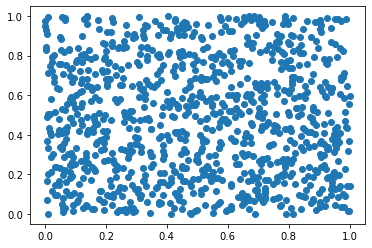

In [2]:
n = 1000
d = 2
X = np.random.rand(n,d)
plt.scatter(X[:,0], X[:,1])
plt.show()

In [3]:
def knn(x, X, k, **kwargs):
    """
    find indices of k-nearest neighbors of x in X
    """
    d = distance.cdist(x.reshape(1,-1), X, **kwargs).flatten()
    return np.argpartition(d, k)[:k]

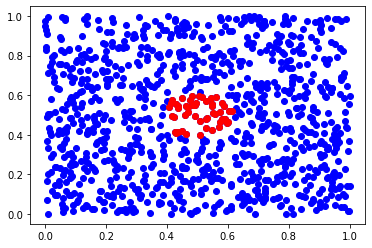

In [4]:
x = np.array([[0.5,0.5]])

inds = knn(x, X, 50)
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

In [5]:
def rnn(x, X, r, **kwargs):
    """
    find r-nearest neighbors of x in X
    """
    d = distance.cdist(x.reshape(1,-1), X, **kwargs).flatten()
    return np.where(d<r)[0]

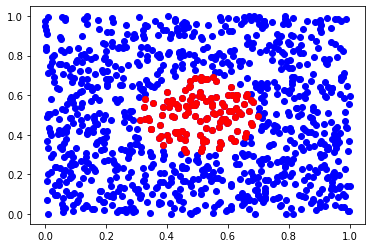

In [6]:
inds = rnn(x, X, 0.2)
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

### Exercise

What is the time complexity of both the above functions?

---

_show your work_

## KD-trees

One of the issues with a brute force solution is that performing a nearest-neighbor query takes $O(n)$ time, where $n$ is the number of points in the data set.  This can become a big computational bottleneck for applications where many nearest neighbor queries are necessary (e.g. building a nearest neighbor graph), or speed is important (e.g. database retrieval)

A kd-tree, or k-dimensional tree is a data structure that can speed up nearest neighbor queries considerably.  They work by recursively partitioning $d$-dimensional data using hyperplanes.

`scipy.spatial` provides both [`KDTree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.html#scipy.spatial.KDTree) (native Python) and [`cKDTree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html#scipy.spatial.cKDTree) (C++).  Note that these are for computing Euclidean nearest neighbors

In [7]:
from scipy.spatial import KDTree, cKDTree

In [8]:
tree = KDTree(X)

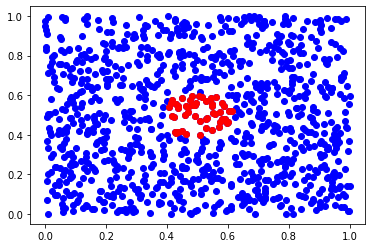

In [9]:
ds, inds =  tree.query(x, 50) # finds 50-th nearest neighbors

plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

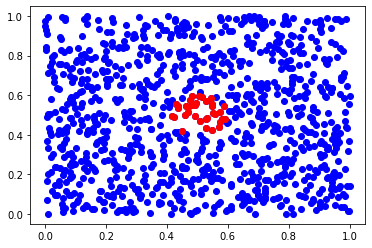

In [10]:
inds = tree.query_ball_point(x, 0.1) # finds neighbors in ball of radius 0.1
inds = inds[0]
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

`cKDTrees` have the same methods

In [11]:
ctree = scipy.spatial.cKDTree(X)

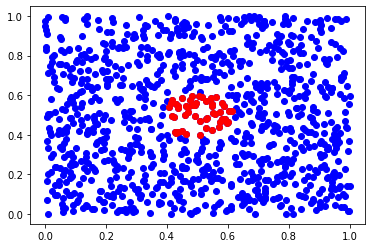

In [12]:
ds, inds =  ctree.query(x, 50) # finds 50-th nearest neighbors

plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

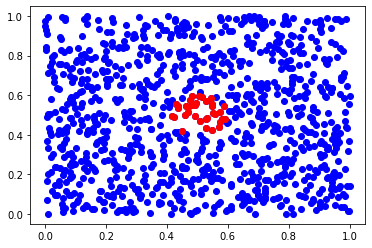

In [13]:
inds = tree.query_ball_point(x, 0.1) # finds neighbors in ball of radius 0.1
inds = inds[0]
plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

### Performance Comparision

In [14]:
import time

k=50

n = 100000
d = 2
Y = np.random.rand(n,d)

t0 = time.time()
inds = knn(x, Y, 50)
t1 = time.time()
print("brute force: {} sec".format(t1 - t0))

t0 = time.time()
tree = KDTree(Y)
ds, inds =  tree.query(x, 50) # finds 50-th nearest neighbors
t1 = time.time()
print("KDTree: {} sec".format(t1 - t0))

t0 = time.time()
ds, inds =  tree.query(x, 50) # finds 50-th nearest neighbors
t1 = time.time()
print("  extra query: {} sec".format(t1 - t0))

t0 = time.time()
tree = cKDTree(Y)
ds, inds =  tree.query(x, 50) # finds 50-th nearest neighbors
t1 = time.time()
print("cKDTree: {} sec".format(t1 - t0))

t0 = time.time()
ds, inds =  tree.query(x, 50) # finds 50-th nearest neighbors
t1 = time.time()
print("  extra query: {} sec".format(t1 - t0))



brute force: 0.005005598068237305 sec
KDTree: 0.511652946472168 sec
  extra query: 0.0012080669403076172 sec
cKDTree: 0.0573427677154541 sec
  extra query: 0.00034618377685546875 sec


## Ball trees

If you want to do nearest neighbor queries using a metric other than Euclidean, you can use a ball tree.  Scikit learn has an implementation in [`sklearn.neighbors.BallTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).

KDTrees take advantage of some special structure of Euclidean space.  Ball Trees just rely on the triangle inequality, and can be used with any metric.

In [15]:
from sklearn.neighbors import BallTree

The list of built-in metrics you can use with `BallTree` are listed under [`sklearn.neighbors.DistanceMetric`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric)

In [16]:
tree = BallTree(X, metric='manhattan')

for a k-nearest neighbors query, you can use the `query` method:

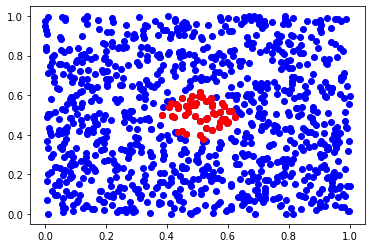

In [17]:
ds, inds = tree.query(x, 50)

plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

for r-nearest neighbors, you use `query_radius` instead of `query_ball_point`.

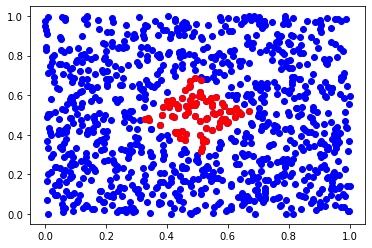

In [18]:
inds = tree.query_radius(x, 0.2)
inds = inds[0]

plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

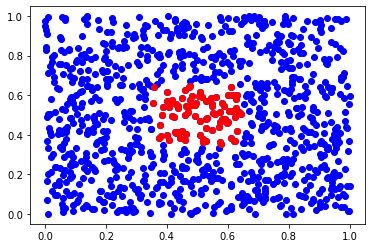

In [19]:
tree = BallTree(X, metric='chebyshev')

inds = tree.query_radius(x, 0.15)
inds = inds[0]

plt.scatter(X[:,0], X[:,1], c='b')
plt.scatter(X[inds,0], X[inds,1], c='r')
plt.show()

## Exercises

1. Compare the performance of `KDTree`, `cKDTree`, and `BallTree` for doing nearest neighbors queries in the Euclidean metric
2. Scikit learn also has a `KDTree` implementation: [`sklearn.neighbors.KDTree`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html#sklearn.neighbors.KDTree) - how does this compare to the KDTree implementations in scipy?

In [ ]:
## Your code here
